# Convolutional Neural Network with Contrastive Loss

Group Member: WuZhanxin

In this section, we introduce Contrastive Loss to match the representations between real-world images and sketch images. The formula for the Contrastive Loss we use is in the Report notebook. 
You can (1) run the training part in the following codes to train a new CNN with Contrastive Loss or (2) directly load my pretrained model.
We also provide Search Engine Accuracy Check and Model History Plot here.

Enjoy the codes~

## Import Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms
import torch
import random
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


## Load our Dataset Structure

In [2]:
random.seed(0)

class TwoImageDataset(Dataset):
    """ Own dataset """

    def __init__(self, quickdraw_dir, realworld_dir, fruit_category, image_size = 255, class_size = 5000):
        """
        Args:
            sketch_dir (string): Directory to all the sketch images.
            realworld_dir (string): Directory to all the real world images.
            fruit_category: list to fruit catogory
            class_size: Num of images in each category
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.quickdraw_dir = quickdraw_dir
        self.realworld_dir = realworld_dir
        self.transform = transform
        self.fruit_category = fruit_category
        self.class_size = class_size
        self.quickdraw_data_dict = dict(np.load(quickdraw_dir))
        self.realworld_data_dict = dict(np.load(realworld_dir))
        self.image_size = image_size
        
        self.transform_img = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize(image_size),
                                                transforms.ToTensor()])
        self.transform_label = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.class_size * len(self.fruit_category)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        class_index = int(idx // self.class_size)
        category =  self.fruit_category[class_index]
        category_idx_real = random.choice(range(self.class_size))
        category_idx_sketch = random.choice(range(self.class_size))
        
        label = np.zeros((len(self.fruit_category), 1))
        label[class_index] = 1
      
        quickdraw_ary =  self.quickdraw_data_dict[category][category_idx_sketch]
        realimage_ary =  self.realworld_data_dict[category][category_idx_real]
        
        sample = {'realworld': realimage_ary, 'sketch': quickdraw_ary, 'label': label}
        if self.transform:
            sample['realworld'] = self.transform_img(sample['realworld'])
            sample['sketch'] = self.transform_img(sample['sketch'])
            sample['label'] = self.transform_label(sample['label'])
        return sample
  

## Load Train and Validation Data

In [3]:
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  
train_quickdraw_dir = './data/compressed_quickdraw_train.npz'
test_quickdraw_dir = './data/compressed_quickdraw_test.npz'
train_realworld_dir = './data/compressed_realworld_train.npz'
test_realworld_dir = './data/compressed_realworld_test.npz'

train_both = TwoImageDataset(train_quickdraw_dir, train_realworld_dir, QURIES, image_size = 255, class_size = 4000)
test_both = TwoImageDataset(test_quickdraw_dir, test_realworld_dir, QURIES, image_size = 255, class_size = 1000)


In [4]:
trainloader = DataLoader(train_both, batch_size= 128, shuffle=True, pin_memory=True, num_workers=32)

In [5]:
testloader = DataLoader(test_both, batch_size= 128, shuffle=True, pin_memory=True, num_workers=32)

## CNN Model Structure

Notice: we use two CNNs for real-world images classification and sketch images classification. Then, the CNNCL combines them together with contrastive loss.

In [6]:
def convbn(in_channels, out_channels, kernel_size, stride, padding, bias):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class CNN(nn.Module):
    def __init__(self, n_channels=3, n_classes=7, dropout=0.1):
        super(CNN, self).__init__()
        layer1   = convbn(n_channels, 64, kernel_size=3, stride=2, padding=1, bias=True)
        layer2   = convbn(64,  128, kernel_size=3, stride=2, padding=1, bias=True)
        layer3   = convbn(128, 192, kernel_size=3, stride=2, padding=1, bias=True)
        layer4   = convbn(192, 256, kernel_size=3, stride=2, padding=1, bias=True)
        layer1_2 = convbn(64,  64,  kernel_size=3, stride=1, padding=0, bias=True)
        layer2_2 = convbn(128, 128, kernel_size=3, stride=1, padding=0, bias=True)
        layer3_2 = convbn(192, 192, kernel_size=3, stride=1, padding=0, bias=True)
        layer4_2 = convbn(256, 256, kernel_size=3, stride=1, padding=0, bias=True)
        
        pool = nn.AdaptiveAvgPool2d((1,1))
        self.layers = nn.Sequential(layer1, layer1_2, layer2, layer2_2, layer3, layer3_2, layer4, layer4_2, pool)
        self.nn = nn.Linear(256, n_classes)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        feats = self.layers(x).flatten(1)
        x = self.nn(self.dropout(feats))
        return x, feats
    
class CNN2(nn.Module):
    def __init__(self, n_channels=3, n_classes=7, dropout=0.1):
        super(CNN2, self).__init__()
        layer1   = convbn(n_channels, 64, kernel_size=3, stride=2, padding=1, bias=True)
        layer2   = convbn(64,  128, kernel_size=3, stride=2, padding=1, bias=True)
        layer3   = convbn(128, 256, kernel_size=3, stride=2, padding=1, bias=True)
        layer1_2 = convbn(64,  64,  kernel_size=3, stride=1, padding=0, bias=True)
        layer2_2 = convbn(128, 128, kernel_size=3, stride=1, padding=0, bias=True)
        layer3_2 = convbn(256, 256, kernel_size=3, stride=1, padding=0, bias=True)
        pool = nn.AdaptiveAvgPool2d((1,1))
        self.layers = nn.Sequential(layer1, layer1_2, layer2, layer2_2, layer3, layer3_2, pool)
        self.nn = nn.Linear(256, n_classes)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        feats = self.layers(x).flatten(1)
        x = self.nn(self.dropout(feats))
        return x, feats

In [7]:
def contrastive_loss(features, labels, temperature):
    
    # compute feature
    feats_matrix = features.unsqueeze(2).expand(-1, -1, features.size(0)) # (batchsize, feats.len, batchsize)
    trans_feats_matrix = feats_matrix.transpose(0, 2)
    sim_matrix = F.cosine_similarity(feats_matrix, trans_feats_matrix, dim=1)
    
    # compute label (batchsize)
    batchsize = labels.shape[0]
    label_matrix = labels.unsqueeze(-1).expand((batchsize, batchsize))
    trans_label_matrix = label_matrix.transpose(0, 1)
    target_matrix = (label_matrix == trans_label_matrix).type(torch.float)
    
    KL = nn.KLDivLoss(reduction="batchmean", log_target=False)
    loss = KL(F.softmax(sim_matrix / temperature).log(), F.softmax(target_matrix / temperature))  
    return loss


class CNNCL(nn.Module):
    def __init__(self, n_classes=7, dropout=0.1, t=0.1):
        super(CNNCL, self).__init__()
        self.t = t
        self.quickdraw_model = CNN()
        self.realworld_model = CNN2()
    def forward(self, quickdraw_x, realworld_x):
        quickdraw_pred, quickdraw_feat = self.quickdraw_model(quickdraw_x)
        realworld_pred, realworld_feat = self.realworld_model(realworld_x)
        return quickdraw_pred, quickdraw_feat, realworld_pred, realworld_feat
    def loss(self, quickdraw_pred, quickdraw_feat, realworld_pred, realworld_feat, y):
        CE = nn.CrossEntropyLoss()
        quickdraw_CE = CE(quickdraw_pred, y)
        realworld_CE = CE(realworld_pred, y)
        label = y.argmax(1)
        CL_quickdraw = contrastive_loss(quickdraw_feat, label, self.t)
        CL_realworld = contrastive_loss(realworld_feat, label, self.t)
        CL_both = contrastive_loss(quickdraw_feat*realworld_feat, label, self.t)
        loss = quickdraw_CE + realworld_CE + CL_quickdraw + CL_realworld + CL_both
        return loss, quickdraw_CE, realworld_CE

## Define Train and Test function

In [8]:
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    num_batches = len(dataloader)
    correct, quickdraw_correct, realworld_correct = 0, 0, 0
    train_loss, quickdraw_loss, realworld_loss = 0, 0, 0
    for _, data in enumerate(dataloader):
        realworld, sketch, y = data['realworld'].to(device), data['sketch'].to(device), data['label'].to(device)

        pred1, feat1, pred2, feat2 = model(sketch, realworld)
        loss, CE_quickdraw, CE_realworld = model.loss(pred1, feat1, pred2, feat2, y.squeeze())
        
        
        label = y.squeeze().argmax(1)
        pred_acc1 = (pred1.argmax(1) == label).type(torch.float)
        pred_acc2 = (pred2.argmax(1) == label).type(torch.float)
        
        quickdraw_correct += pred_acc1.sum().item()
        realworld_correct += pred_acc2.sum().item()
        correct += (pred_acc1 == pred_acc2).type(torch.float).sum().item()
        
        quickdraw_loss += CE_quickdraw.item()
        realworld_loss += CE_realworld.item()
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if _ % 100 == 0:
            loss, current = loss.item(), _ * len(pred1)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    quickdraw_loss /= num_batches
    realworld_loss /= num_batches
    quickdraw_correct /= size
    realworld_correct /= size
    correct /= size
    
    return  correct, quickdraw_correct, realworld_correct, train_loss, quickdraw_loss, realworld_loss

def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, quickdraw_loss, realworld_loss, correct, realworld_correct, quickdraw_correct = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
         for _, data in enumerate(dataloader):
            realworld, sketch, y = data['realworld'].to(device), data['sketch'].to(device), data['label'].to(device)
            pred1, feat1, pred2, feat2 = model(sketch, realworld)
            label = y.squeeze().argmax(1)
            pred_acc1 = (pred1.argmax(1) == label).type(torch.float)
            pred_acc2 = (pred2.argmax(1) == label).type(torch.float)
            
            quickdraw_correct += pred_acc1.sum().item()
            realworld_correct += pred_acc2.sum().item()
            correct += (pred_acc1 == pred_acc2).type(torch.float).sum().item()
            
            CL_loss, CE_quickdraw, CE_realworld = model.loss(pred1, feat1, pred2, feat2, y.squeeze())
            test_loss += CL_loss.item()
            quickdraw_loss += CE_quickdraw.item()
            realworld_loss += CE_realworld.item()
            
    test_loss /= num_batches
    quickdraw_loss /= num_batches
    realworld_loss /= num_batches
    quickdraw_correct /= size
    realworld_correct /= size
    correct /= size
    print("------------ Test -----------")
    print(f"Search Engine Accuracy: {(100*correct):>2f}%, Avg loss: {test_loss:>8f}")
    print(f"Realworld Accuracy: {(100*realworld_correct):>2f}%")
    print(f"Quickdraw Accuracy: {(100*quickdraw_correct):>2f}%\n")
    return correct, quickdraw_correct, realworld_correct, test_loss, quickdraw_loss, realworld_loss


## Define Training Parameters

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
CNN_CL = CNNCL().to(device)

CNN_CL_epochs = 20
CNN_CL_optimizer = torch.optim.AdamW(CNN_CL.parameters(), lr= 2e-5, weight_decay=1e-4)
CNN_CL_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(CNN_CL_optimizer, T_max=CNN_CL_epochs)


## Train and Test Procedure

Notice: If you want to load our pretrained model, please skip this section.

In [26]:
test_losses = []
test_accuracy = []
test_quickdraw_accuracy = []
test_realworld_accuracy = []
test_quickdraw_loss = []
test_realworld_loss = []

train_losses = []
train_accuracy = []
train_quickdraw_accuracy = []
train_realworld_accuracy = []
train_quickdraw_loss = []
train_realworld_loss = []

random.seed(0)

for t in range(CNN_CL_epochs):
    print(f"---------- Epoch {t+1} ----------")
    train_acc, train_q_acc, train_r_acc, train_loss, train_q_loss, train_r_loss = train(trainloader, CNN_CL, CNN_CL_optimizer)
    test_acc, test_q_acc, test_r_acc, test_loss, test_q_loss, test_r_loss = test(testloader, CNN_CL)
    CNN_CL_scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    train_quickdraw_accuracy.append(train_q_acc)
    train_realworld_accuracy.append(train_r_acc)
    train_quickdraw_loss.append(train_q_loss)
    train_realworld_loss.append(train_r_loss)

    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    test_quickdraw_accuracy.append(test_q_acc)
    test_realworld_accuracy.append(test_r_acc)
    test_quickdraw_loss.append(test_q_loss)
    test_realworld_loss.append(test_r_loss)

    

---------- Epoch 1 ----------
Loss: 9.928162  [    0/28000]
Loss: 7.136716  [12800/28000]
Loss: 6.572839  [25600/28000]
------------ Test -----------
Search Engine Accuracy: 52.700000%, Avg loss: 6.528894
Realworld Accuracy: 66.200000%
Quickdraw Accuracy: 58.871429%

---------- Epoch 2 ----------
Loss: 6.580307  [    0/28000]
Loss: 6.278971  [12800/28000]
Loss: 5.516556  [25600/28000]
------------ Test -----------
Search Engine Accuracy: 63.271429%, Avg loss: 5.428853
Realworld Accuracy: 75.642857%
Quickdraw Accuracy: 76.657143%

---------- Epoch 3 ----------
Loss: 5.462167  [    0/28000]
Loss: 5.256740  [12800/28000]
Loss: 5.331054  [25600/28000]
------------ Test -----------
Search Engine Accuracy: 65.000000%, Avg loss: 4.895337
Realworld Accuracy: 74.342857%
Quickdraw Accuracy: 81.771429%

---------- Epoch 4 ----------
Loss: 4.824838  [    0/28000]
Loss: 5.105010  [12800/28000]
Loss: 4.374037  [25600/28000]
------------ Test -----------
Search Engine Accuracy: 70.100000%, Avg loss: 

In [27]:
realworldloader = DataLoader(test_both, batch_size= 100, shuffle=True, pin_memory=True, num_workers=32)
CNN_CL.eval()
realworld_pred_lst = []
realworld_y_lst = []
with torch.no_grad():
     for _, data in enumerate(realworldloader):
        realworld, sketch, y = data['realworld'].to(device), data['sketch'].to(device), data['label'].to(device)
        pred1, feat1, pred2, feat2 = CNN_CL(sketch, realworld)
        realworld_pred_lst.append(pred2)
        realworld_y_lst.append(y.squeeze())
realworld_pred = torch.cat(realworld_pred_lst,0)
realworld_y = torch.cat(realworld_y_lst,0)
print('Finish Creating Real World Image Feature!')

retrieve_quickdraw_loader = DataLoader(test_both, batch_size= 1, shuffle=True, pin_memory=True, num_workers=32)

def search_engine_evaluation(retrieve_quickdraw_loader, realworld_pred, k = 3):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    count_accuracy = 0
    CNN_CL.eval()
    with torch.no_grad():
         for _, data in enumerate(retrieve_quickdraw_loader):
            realworld, sketch, y = data['realworld'].to(device), data['sketch'].to(device), data['label'].to(device)
            pred1, feat1, pred2, feat2 = CNN_CL(sketch, realworld)
            quickdraw_y = y.squeeze()
            
            realworld_pred = nn.functional.normalize(realworld_pred)
            quickdraw_pred = nn.functional.normalize(pred1)
            
            cos_similarity = cos(realworld_pred,quickdraw_pred)
            topk_index = torch.topk(cos_similarity, k).indices
            count_accuracy += (realworld_y[topk_index].argmax(1) == quickdraw_y.argmax()).sum()
    final_acc = (count_accuracy/(len(retrieve_quickdraw_loader) * k ) )
    print(f'Find Top {k} Realworld Images Retreive Accuracy: {(100*final_acc):>2f}%')
    return final_acc

test_k = [1,3,5,10,20]
topk_acc = []
for k in test_k:
    k_acc = search_engine_evaluation(retrieve_quickdraw_loader, realworld_pred, k)
    topk_acc.append(k_acc.item())

Finish Creating Real World Image Feature!
Find Top 1 Realworld Images Retreive Accuracy: 75.599998%
Find Top 3 Realworld Images Retreive Accuracy: 81.690475%
Find Top 5 Realworld Images Retreive Accuracy: 84.057144%
Find Top 10 Realworld Images Retreive Accuracy: 85.868576%
Find Top 20 Realworld Images Retreive Accuracy: 85.303566%


In [30]:
torch.save(CNN_CL.state_dict(), './model/CNNCL.pth')

## Load our Pretrained Model

In [10]:
CNN_CL = CNNCL().to(device)
CNN_CL.load_state_dict(torch.load('./model/CNNCL.pth'))

<All keys matched successfully>

## Test Search Engine Accuracy

The test_k includes all the k value we want to test, where k means the number of real-world images we will return for each sketch.

In [14]:
realworldloader = DataLoader(test_both, batch_size= 100, shuffle=True, pin_memory=True, num_workers=32)
CNN_CL.eval()
realworld_pred_lst = []
realworld_y_lst = []
with torch.no_grad():
     for _, data in enumerate(realworldloader):
        realworld, sketch, y = data['realworld'].to(device), data['sketch'].to(device), data['label'].to(device)
        pred1, feat1, pred2, feat2 = CNN_CL(sketch, realworld)
        realworld_pred_lst.append(pred2)
        realworld_y_lst.append(y.squeeze())
realworld_pred = torch.cat(realworld_pred_lst,0)
realworld_y = torch.cat(realworld_y_lst,0)
print('Finish Creating Real World Image Feature!')

retrieve_quickdraw_loader = DataLoader(test_both, batch_size= 1, shuffle=True, pin_memory=True, num_workers=32)

def search_engine_evaluation(retrieve_quickdraw_loader, realworld_pred, k = 3):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    count_accuracy = 0
    CNN_CL.eval()
    with torch.no_grad():
         for _, data in enumerate(retrieve_quickdraw_loader):
            realworld, sketch, y = data['realworld'].to(device), data['sketch'].to(device), data['label'].to(device)
            pred1, feat1, pred2, feat2 = CNN_CL(sketch, realworld)
            quickdraw_y = y.squeeze()
            
            realworld_pred = nn.functional.normalize(realworld_pred)
            quickdraw_pred = nn.functional.normalize(pred1)
            
            cos_similarity = cos(realworld_pred,quickdraw_pred)
            topk_index = torch.topk(cos_similarity, k).indices
            count_accuracy += (realworld_y[topk_index].argmax(1) == quickdraw_y.argmax()).sum()
    final_acc = (count_accuracy/(len(retrieve_quickdraw_loader) * k ) )
    print(f'Find Top {k} Realworld Images Retreive Accuracy: {(100*final_acc):>2f}%')
    return final_acc

test_k = [1,3,5,10,20]
topk_acc = []
for k in test_k:
    k_acc = search_engine_evaluation(retrieve_quickdraw_loader, realworld_pred, k)
    topk_acc.append(k_acc.item())

Finish Creating Real World Image Feature!
Find Top 1 Realworld Images Retreive Accuracy: 78.742859%
Find Top 3 Realworld Images Retreive Accuracy: 82.728569%
Find Top 5 Realworld Images Retreive Accuracy: 83.165718%
Find Top 10 Realworld Images Retreive Accuracy: 85.301430%
Find Top 20 Realworld Images Retreive Accuracy: 83.523575%


## Save all the results 

### Important Notice: only run the following codes when you retrain the model; otherwise, it will cover our submitted parameters. 

In [13]:
import pickle

model_history = {
    "epoch": range(len(train_losses)),
    "train_loss": train_losses,
    "train_acc": train_accuracy,
    "val_loss": test_losses,
    "val_acc": test_accuracy,

    # Please save the following metric
    "train_realworld_acc": train_realworld_accuracy,
    "train_quickdraw_acc": train_quickdraw_accuracy,
    "val_realworld_acc": test_realworld_accuracy,
    "val_quickdraw_acc": test_quickdraw_accuracy,
    "train_realworld_loss": train_realworld_loss,
    "train_quickdraw_loss": train_quickdraw_loss,
    "val_realworld_loss": test_realworld_loss,
    "val_quickdraw_loss": test_quickdraw_loss,
    "k_choice": test_k, # [1,3,5,10,20]
    "topk_acc": topk_acc
}


def save_model_history(metrics, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(metrics, file)

def load_model_history(filepath):
    with open(filepath, 'rb') as file:
        metrics = pickle.load(file)
    return metrics

In [ ]:
save_model_history(model_history, './results/CNNCL.pkl')

## Load Our Model History

In [ ]:
model_history = load_model_history('./results/CNNCL.pkl')
model_history

## Plot Our Model History

Notice: for more information and plot for the model history, please check the Report notebook.

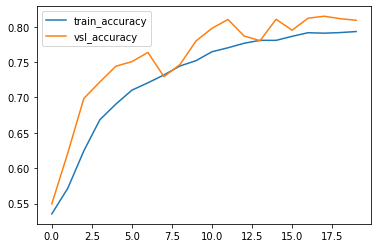

In [27]:
# plt.plot(range(len(train_losses)), train_losses, label = ' training loss')
# plt.plot(range(len(test_losses)), test_losses, label = 'test loss')
# train_accuracy= model_history['train_acc']
# test_accuracy =  model_history['train_acc']
plt.plot(range(len(train_accuracy)), train_accuracy, label = 'train_accuracy')
plt.plot(range(len(test_accuracy)), test_accuracy, label = 'val_accuracy')

plt.legend()